Average features per genre:
    Genre  AvgDance  AvgEnergy  AvgLoudness  AvgAcoustic
0     EDM  0.558581   0.577731    -5.610382     0.422875
1  HipHop  0.430618   0.478695    -5.535572     0.522437
2     Pop  0.525501   0.572262    -5.120909     0.547030
3    Rock  0.489784   0.432747    -3.749554     0.577985

Hit rate per genre:
    Genre   HitRate
0     EDM  0.291667
1  HipHop  0.400000
2     Pop  0.500000
3    Rock  0.400000


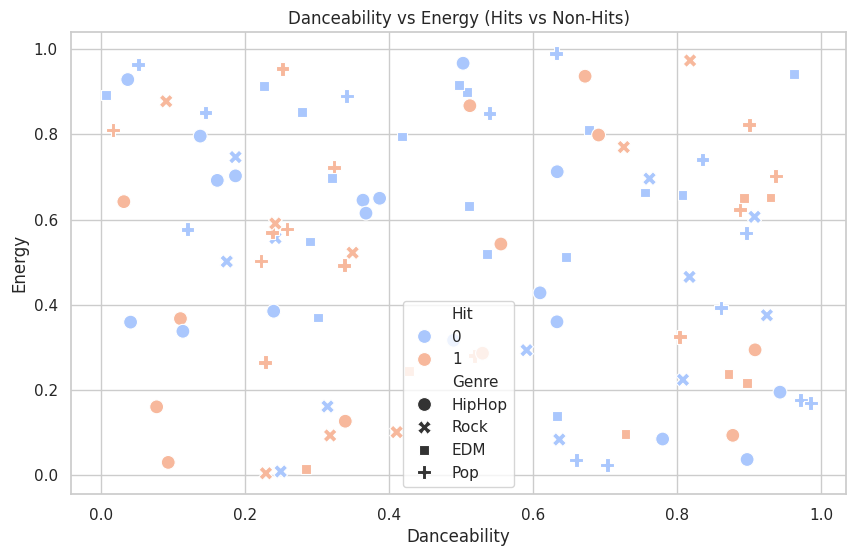

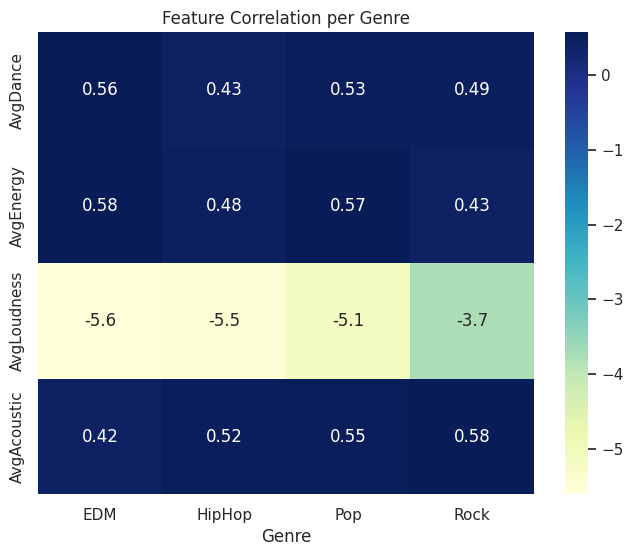

Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.57      0.40      0.47        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.54        20
weighted avg       0.55      0.55      0.54        20



/tmp/ipython-input-141539314.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Danceability','Energy'], y=importance, palette="viridis")


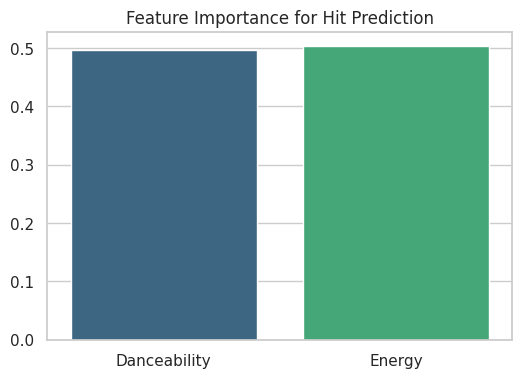

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

sns.set(style="whitegrid")

# Step 1: Create SQLite DB
conn = sqlite3.connect(":memory:")

np.random.seed(42)
data = pd.DataFrame({
    "Song": [f"Song{i}" for i in range(1, 101)],
    "Artist": np.random.choice(["ArtistA","ArtistB","ArtistC","ArtistD"], 100),
    "Genre": np.random.choice(["Pop","Rock","HipHop","EDM"], 100),
    "Danceability": np.random.rand(100),
    "Energy": np.random.rand(100),
    "Loudness": np.random.uniform(-10,0,100),
    "Acousticness": np.random.rand(100),
    "Hit": np.random.choice([0,1], 100)  # 1 = hit
})

# Load into SQLite
data.to_sql("spotify", conn, index=False, if_exists="replace")

# Step 3: SQL Insights Queries

# Average feature values per genre
query = """
SELECT Genre, AVG(Danceability) as AvgDance, AVG(Energy) as AvgEnergy,
       AVG(Loudness) as AvgLoudness, AVG(Acousticness) as AvgAcoustic
FROM spotify
GROUP BY Genre
"""
genre_features = pd.read_sql(query, conn)
print("Average features per genre:")
print(genre_features)

# Hit rate per genre
query2 = """
SELECT Genre, SUM(Hit)*1.0/COUNT(*) as HitRate
FROM spotify
GROUP BY Genre
"""
genre_hitrate = pd.read_sql(query2, conn)
print("\nHit rate per genre:")
print(genre_hitrate)

# Step 4: SQL + Python Visualization

# Scatter plot: Danceability vs Energy, color = Hit
df = pd.read_sql("SELECT Danceability, Energy, Hit, Genre FROM spotify", conn)
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="Danceability", y="Energy", hue="Hit", style="Genre", palette="coolwarm", s=100)
plt.title("Danceability vs Energy (Hits vs Non-Hits)")
plt.show()

# Heatmap: correlation of features per genre
corr = genre_features.set_index('Genre').T
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Feature Correlation per Genre")
plt.show()

# Step 5: Predictive Modeling (Hit Classification)
X = df[['Danceability','Energy']]
y = df['Hit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Step 6: Feature Importance
importance = clf.feature_importances_
plt.figure(figsize=(6,4))
sns.barplot(x=['Danceability','Energy'], y=importance, palette="viridis")
plt.title("Feature Importance for Hit Prediction")
plt.show()
